# Libraries

In [4]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from pandas.tseries.offsets import DateOffset
import time
import decimal
import os
import scipy.stats as stats
from scipy.stats import norm
import plotly.graph_objs as go
import plotly.offline as pyoff
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
from tqdm import tqdm_notebook as tqdm

In [5]:
# ARIMA Model
from statsmodels.tsa.stattools import adfuller # ADF, check for seasonality of data
from statsmodels.tsa.arima_model import ARIMA # ARIMA engine
import pmdarima as pm # for automating ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.special import boxcox, inv_boxcox
import statsmodels.api as sm

In [6]:
# LSTM packages
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import adam

# Establish datapath

In [7]:
# Datapath
os.chdir('C:\\Users\\asus\\Documents\\Python Projects\\Trading - Research and Backtest\\AAPL')
datapath = os.getcwd() + '\\Databases\\'
files = []
for (dirpath, dirnames, filenames) in os.walk(datapath):
    files.extend(filenames)
    break
print(files)

['AAPL-15min.csv', 'AAPL-1d.csv', 'AAPL-1min.csv', 'AAPL-1mo.csv', 'AAPL-1wk.csv', 'AAPL-2min.csv', 'AAPL-30min.csv', 'AAPL-3mo.csv', 'AAPL-5d.csv', 'AAPL-5min.csv', 'AAPL-60min.csv', 'AAPL-90min.csv']


In [18]:
# Load data
interval = '15min'
dt = pd.read_csv(datapath+'AAPL-'+interval+'.csv', parse_dates=True, index_col='Date')

In [8]:
# Load data
interval = 'daily'
intraday = isinstance(interval, (int, float, complex))
time_window = str(interval) + 'min'
if intraday:
    dt = pd.read_csv(datapath + [s for s in files if '-'+time_window in s][0], index_col = 'date', parse_dates = True)
else:
    dt = pd.read_csv(datapath + [s for s in files if '-'+interval in s][0], index_col = 'date', parse_dates = True)
dt2 = pd.DataFrame(dt.loc['2020-03-01':]['Close']).copy()

IndexError: list index out of range

In [63]:
dt

,High,Low,Open,Close,Volume,Adj Close
date,,,,,,
2019-01-01,26000.0,26000.0,26000.0,26000.0,0.0,25246.753906
2019-01-02,26225.0,26000.0,26000.0,26200.0,7191200.0,25440.958984
2019-01-03,26100.0,25575.0,26000.0,25900.0,14471600.0,25149.652344
2019-01-04,26025.0,25625.0,25875.0,26025.0,10293000.0,25271.031250
2019-01-07,26625.0,26225.0,26325.0,26225.0,14687600.0,25465.236328
...,...,...,...,...,...,...
2020-07-23,31075.0,30700.0,30900.0,31000.0,16805300.0,31000.000000
2020-07-24,31000.0,30500.0,31000.0,30500.0,11673300.0,30500.000000
2020-07-27,30700.0,30000.0,30500.0,30500.0,8394500.0,30500.000000


# LSTM Model

## Model training on train-test split set

In [64]:
# Split data into train-test and scale
# Split
split_percentage = 0.8; use_percent = True
split_int = -40
if use_percent:
    train = pd.DataFrame(dt2['Close'].iloc[:int(len(dt2)*split_percentage)])
    test = pd.DataFrame(dt2['Close'].iloc[int(len(dt2)*split_percentage):])
else:
    train = pd.DataFrame(dt2['4. close'].iloc[:split_int])
    test = pd.DataFrame(dt2['4. close'].iloc[split_int:])
    pass
# Scale
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [84]:
# LSTM Model and train model to train set
np.random.seed(14)
n_input = len(test)
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)
lstm_model = Sequential()
lstm_model.add(LSTM(60, activation='tanh', input_shape=(n_input, n_features)))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
n_epochs = 2000
for n in tqdm(range(n_epochs)):
    lstm_model.fit_generator(generator,epochs=1, shuffle = False, verbose = 0)
    lstm_model.reset_states()

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:36<00:00,  9.22it/s]


## Predictions on test data and in the future

In [94]:
# Predictions and plotting, result: df_proj
do_predict = ['fixed', 'walk-forward', 'future']
for x in do_predict:
    pred_list = []
    batch = train[-n_input:].reshape((1, n_input, n_features))
    if x == 'fixed':
        for i in tqdm(range(n_input)):
            pred_list.append(lstm_model.predict(batch)[0]) 
            batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
            pass
        df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index = dt2[-n_input:].index, 
                                  columns = ['Predictions'])
        df_test = pd.concat([dt2, df_predict], axis = 1)
    elif x == 'walk-forward':
        for i in tqdm(range(n_input)):
#             if (counter % 2) == 0:
#                 train2 = np.append(train, test[i-1][0]).reshape(-1, 1)
#                 generator = TimeseriesGenerator(train2, train2, length=n_input, batch_size=6)
#                 lstm_model.fit_generator(generator,epochs=1, verbose = 0)
#                 lstm_model.reset_states()
            yhat = lstm_model.predict(batch)[0]
            pred_list.append(yhat)
            batch = np.append(batch[:,1:,:],[[test[i]]],axis=1)
            pass
        df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index = dt2[-n_input:].index, 
                          columns = ['Predictions walk forward'])
        df_test = pd.concat([df_test, df_predict], axis = 1)
    elif x == 'future':
        train2 = pd.DataFrame(dt2['Close'])
        scaler.fit(train2)
        train2 = scaler.transform(train2)
        n_input = len(test)
        n_features = 1
        generator = TimeseriesGenerator(train2, train2, length=n_input, batch_size=40)
        lstm_model.fit_generator(generator,epochs=150, verbose = 0)
        batch = train2[-n_input:].reshape((1, n_input, n_features))
        for i in tqdm(range(n_input)):
            pred_list.append(lstm_model.predict(batch)[0])      
            batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
            pass
        add_dates = [dt2.index[-1] + DateOffset(days = x) for x in range(0, n_input + 1)]
        future_dates = pd.DataFrame(index = add_dates[1:], columns = dt2.columns)
        df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index = future_dates[-n_input:].index, 
                                  columns = ['Future Predictions'])
        df_proj = pd.concat([df_test, df_predict], axis = 1)
    pass
# Plot
if 1:
    plot_data = [go.Scatter(x = df_test.index, y = df_test['Close'], name = 'Training'),
                 go.Scatter(x = df_test.index, y = df_test['Predictions'], name = 'Predictions Fixed'),
                 go.Scatter(x = df_test.index, y = df_test['Predictions walk forward'], name = 'Predictions WF'),
                 go.Scatter(x = df_proj.index, y = df_proj['Future Predictions'], name = 'Future Predictions'),
                ]
    plot_layout = go.Layout(title = 'AAPL Price Predictions')
    fig = go.Figure(data = plot_data, layout = plot_layout)
    pyoff.iplot(fig)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 285.81it/s]


In [103]:
plot_data = [go.Scatter(x = df_test.index, y = df_test['Close'], name = 'Training'),
             go.Scatter(x = df_test.index, y = df_test['Predictions'], name = 'Predictions Fixed'),
             go.Scatter(x = df_test.index, y = df_test['Predictions walk forward'], name = 'Predictions WF'),
             go.Scatter(x = df_proj.index, y = df_proj['Future Predictions'], name = 'Future Predictions'),
            ]
plot_layout = go.Layout(title = 'BBCA.JK Price Predictions')
fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

In [67]:
# Fixed prediction on test data, Plotting
# pred_list = []
# batch = train[-n_input:].reshape((1, n_input, n_features))
# for i in range(n_input):
#     pred_list.append(model.predict(batch)[0]) 
#     batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
#     pass
# df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index = dt2[-n_input:].index, columns = ['Predictions'])
# df_test = pd.concat([dt2, df_predict], axis = 1)
# # Plot
# if 1:
#     plt.figure(figsize=(20, 5))
#     plt.plot(df_test.index, df_test['4. close'], label = 'Training')
#     plt.plot(df_test.index, df_test['Predictions'], color='red', label = 'Predictions')
#     plt.legend(loc='best', fontsize='xx-large')
#     plt.xticks(fontsize=18)
#     plt.yticks(fontsize=16)
#     plt.show()

In [68]:
# Walk forward prediction on test data
# batch = train[-n_input:].reshape((1, n_input, n_features))
# pred_list = []
# for i in range(n_input):
# #     if (counter % 2) == 0:
# #         train2 = np.append(train, test[i-1][0]).reshape(-1, 1)
# #         generator = TimeseriesGenerator(train2, train2, length=n_input, batch_size=6)
# #         model.fit_generator(generator,epochs=1, verbose = 0)
# #         model.reset_states()
#     yhat = model.predict(batch)[0]
#     pred_list.append(yhat)
#     batch = np.append(batch[:,1:,:],[[test[i]]],axis=1)
#     pass
# df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index = dt2[-n_input:].index, 
#                           columns = ['Predictions walk forward'])
# df_test = pd.concat([df_test, df_predict], axis = 1)
# # Plot
# if 1:
#     plot_data = [go.Scatter(x = df_test.index, y = df_test['4. close'], name = 'Training'),
#                  go.Scatter(x = df_test.index, y = df_test['Predictions'], name = 'Predictions Fixed'),
#                  go.Scatter(x = df_test.index, y = df_test['Predictions walk forward'], name = 'Predictions WF'),
#                 ]
#     plot_layout = go.Layout(title = 'AAPL Price Wak forward')
#     fig = go.Figure(data = plot_data, layout = plot_layout)
#     pyoff.iplot(fig)    

In [69]:
# Prediction beyond data
# # Train all dataset
# train = pd.DataFrame(dt2['4. close'])
# scaler.fit(train)
# train = scaler.transform(train)
# n_input = len(test)
# n_features = 1
# generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)
# model.fit_generator(generator,epochs=20, verbose = 0)
# # Predict beyond dataset
# pred_list = []  
# batch = train[-n_input:].reshape((1, n_input, n_features))
# for i in range(n_input):
#     pred_list.append(model.predict(batch)[0])      
#     batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
#     pass
# add_dates = [dt2.index[-1] + DateOffset(days = x) for x in range(0, n_input + 1)]
# future_dates = pd.DataFrame(index = add_dates[1:], columns = dt2.columns)
# df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index = future_dates[-n_input:].index, 
#                           columns = ['Future Predictions'])
# df_proj = pd.concat([df_test, df_predict], axis = 1)
# # Plot data
# if 1:
#     plot_data = [go.Scatter(x = df_proj.index, y = df_proj['4. close'], name = 'Past Data'),
#                  go.Scatter(x = df_proj.index, y = df_proj['Future Predictions'], name = 'Future Predictions'),
#                 ]
#     plot_layout = go.Layout(title = 'AAPL Price Prediction')
#     fig = go.Figure(data = plot_data, layout = plot_layout)
#     pyoff.iplot(fig)

# ARIMA Model

In [70]:
# Functions
def Seasonality_check(time_series, alpha = 0.05):
    '''
    Pass a time series, return an ADF report on data seasonality
    H0: data is non-seasonal, default alpha = 0.05
    Accept H0 if p-value > alpha
    '''
    result = adfuller(time_series)
    print('Augmented Dickey Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= alpha:
        print('Strong evidence against H0. Data is stationary')
    else:
        print('Weak evidence against H0. Data is non-stationary')
    return result[1]
def LjungBox(lags = None):
    '''
    This functions return p value of model's residual, to determine whether its a white noise or not.
    p-value < 0.05 --> H0: residual is NOT a white noise
    What we want: the residual IS a white noise
    Insert lags as in d in ARIMA
    '''
    pvalue = sm.stats.acorr_ljungbox(model.resid(), lags = [lags])[1][0]
    if pvalue > 0.05:
        print('Great! LjungBox Test: Model Residual is white noise {:,.3f}'.format(pvalue))
    else:
        print('Hmm...LjungBox Test: Model Residual is not a white noise {:,.3f}'.format(pvalue))
    pass

In [71]:
# ARIMA Data, Train-test split
use_log = False
split_percentage = 0.8; use_percent = False
split_int = -40
if use_log:
    dt2['log price'] = np.log(dt2['Close'])
    if use_percent:
        dataset = dt2['log price']
        train_data = dt2['log price'][:int(len(dt2)*split_percentage)]
        test_data = dt2['log price'][int(len(dt2)*split_percentage):]
    else:
        dataset = dt2['log price']
        train_data = dt2['log price'][:split_int]
        test_data = dt2['log price'][split_int:]        
else:
    if use_percent:
        dataset = dt2['Close']
        train_data = dt2['Close'][:int(len(dt2)*0.80)]
        test_data = dt2['Close'][int(len(dt2)*0.80):]
    else:
        dataset = dt2['Close']
        train_data = dt2['Close'][:split_int]
        test_data = dt2['Close'][split_int:-20]          
train_ar = train_data.values
test_ar = test_data.values

## Time Series Decomposition

Augmented Dickey Fuller Test:
ADF Test Statistic : -1.7386065968555344
p-value : 0.4113389305167955
#Lags Used : 4
Number of Observations Used : 46
Weak evidence against H0. Data is non-stationary
Use Box-Cox Transfomation


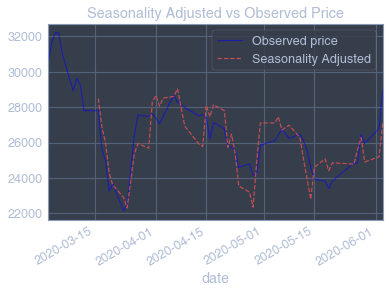

In [72]:
# Time series decomposition and Data Preparation
decompose_freq = 10
if use_log:
    TS_decompose = seasonal_decompose(train_data, model='multiplicative', freq = decompose_freq)
elif not use_log:
    TS_decompose = seasonal_decompose(train_data, model='additive', freq = decompose_freq, two_sided = False)
    pass
if 0: # Plot Time Decomposition
    fig, ax = plt.subplots(4, 1, figsize = (20, 12))
    ax[0].plot(TS_decompose.observed); ax[0].set(ylabel="Observed", title = 'Price Decomposition')
    ax[1].plot(TS_decompose.trend); ax[1].set(ylabel="Trend")
    ax[2].plot(TS_decompose.seasonal); ax[2].set(ylabel="Seasonality")
    ax[3].plot(TS_decompose.resid); ax[3].set(ylabel="Residual")
    plt.tight_layout()
    pass
#-------------------Rolling variance-------------------#
roll_var = TS_decompose.observed.rolling(decompose_freq).var()
if 0 : roll_var.plot() # Plot
result = Seasonality_check(roll_var.dropna()) # if non stationary, use box-cox transformation
if result > 0.05:
    transform_boxcox = True
    idempotent_boxcox = True
    print('Use Box-Cox Transfomation')
else:
    transform_boxcox = False
    idempotent_boxcox = False   
    pass
#-------------------Create a seasonally adjusted price-------------------#
if use_log:
    sea_adj = (TS_decompose.trend *  TS_decompose.resid) / TS_decompose.seasonal
else:
    sea_adj = (TS_decompose.trend +  TS_decompose.resid) - TS_decompose.seasonal
# Plot
if 1:
    (TS_decompose.observed).plot(label = 'Observed price', color = 'blue', alpha = 0.5, 
                                 title = 'Seasonality Adjusted vs Observed Price')
    sea_adj.plot(label = 'Seasonality Adjusted', color = 'r', style = '--')
    plt.legend()
    pass
#-------------------Check Seasonality-------------------# 
if 0: # Optional, can skip if using auto-arima 
    # Check Seasonality
    difference = (sea_adj - sea_adj.shift(1))
    _ = Seasonality_check(difference.dropna()) # increase differencing until data is stationary, skip if using auto-arima
    pass
#-------------------ACF & PACF-------------------#
if 0: # Optional, can skip if using auto-arima
    fig_acf = plot_acf(difference.dropna())
    fig_pacf = plot_pacf(difference.dropna())
    pass

In [73]:
# ARIMA Optimization of parameters and predictions
if 1: # Optimization
    if transform_boxcox and idempotent_boxcox:
        sea_adj = boxcox(sea_adj, 3)
        test_ar = boxcox(test_ar, 3)
        idempotent_boxcox = False
    model = pm.auto_arima(sea_adj.dropna(), start_p = 0, start_q = 0,
                      test = 'adf', # use adftest to find the optima 'd'
                      max_p = 3, max_q = 3,
                      m = 1, # frequency of the series
                      d = None, # Let the model determine 'd'
                      seasonal = False, # No seasonality
                      start_P = 0,
                      D = 0,
                      trace = True,
                      error_action = 'ignore',
                      suppress_warnings = True,
                      stepwise = True)
    print(model.summary())
    pass
if 1: # Predictions
    history = [x for x in sea_adj.dropna()]
    predictions = list()
    upper_series = list();lower_series = list(); stderr = list()
    for t in range(len(test_ar) + 22):
        output = model.predict(1, return_conf_int=True)
        model_fit = model.fit(history)
        yhat = np.float(output[0]); lower = output[1][0][0]; upper = output[1][0][1]; std = (upper - yhat)/2
        predictions.append(yhat); lower_series.append(lower); upper_series.append(upper); stderr.append(std)
        if t > len(test_ar)-1:
            obs = predictions[-1]
        else:
            obs = test_ar[t]
        history.append(obs)
        pass
    if use_log:
        train_data = np.exp(train_data)
        test_data = np.exp(test_data)
        predictions = np.exp(predictions)
        lower_series = np.exp(lower_series)
        upper_series = np.exp(upper_series)
        stderr = (upper_series - predictions) / 2
        pass
    if transform_boxcox:
        predictions = inv_boxcox(predictions, 3)
        lower_series = inv_boxcox(lower_series, 3)
        upper_series = inv_boxcox(upper_series, 3)
        stderr = (upper_series - predictions) / 2
        pass
    index_range = dt2['Close'][-40:].index
    predictions = pd.Series(predictions[2:], index = index_range)
    lower_series = pd.Series(lower_series[2:], index = index_range)
    upper_series = pd.Series(upper_series[2:], index = index_range)
    print('Prediction done')
    pass
if 1: # Plot Diagnostic
    model_fit.plot_diagnostics(figsize=(12,10))
    plt.show()
    plt.tight_layout()
    LjungBox(lags = model.order[1])
    pass

Fit ARIMA: order=(0, 0, 0); AIC=2926.556, BIC=2930.380, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0); AIC=2884.084, BIC=2889.821, Fit time=0.030 seconds
Fit ARIMA: order=(0, 0, 1); AIC=2883.747, BIC=2889.483, Fit time=0.053 seconds
Fit ARIMA: order=(1, 0, 1); AIC=2878.318, BIC=2885.966, Fit time=0.070 seconds
Fit ARIMA: order=(1, 0, 2); AIC=2878.059, BIC=2887.619, Fit time=0.270 seconds
Fit ARIMA: order=(2, 0, 3); AIC=2876.598, BIC=2889.982, Fit time=0.291 seconds
Fit ARIMA: order=(1, 0, 3); AIC=2874.599, BIC=2886.071, Fit time=0.220 seconds
Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 3); AIC=2873.516, BIC=2883.076, Fit time=0.208 seconds
Total fit time: 1.179 seconds
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   50
Model:                     ARMA(0, 3)   Log Likelihood               -1431.758
Method:                       css-

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [ ]:
test_data

In [ ]:
# Walk Forward PLot on test data
if 1: # use pyplot
    plot_data = [go.Scatter(x = train_data.index, y = train_data, name = 'Training', line = dict(color = 'light blue')),
                 go.Scatter(x = test_data.index, y = test_data, name = 'Test Data', line=dict(color="red")),
                 go.Scatter(x = test_data.index, y = lower_series, line=dict(color = 'rgba(169,169,169, 0.3)'), 
                            name = 'lower series'),
                 go.Scatter(x = test_data.index, y = upper_series, fill='tonexty', fillcolor= 'rgba(169,169,169, 0.3)',
                            line=dict(color = 'rgba(169,169,169, 0.3)'), name = 'upper series'),
                 go.Scatter(x = test_data.index, y = predictions, name = 'Predictions Fixed', line=dict(color="darkgreen")),
#                  go.Scatter(x = valid.index, y = predictions[-20:], name = 'Predictions Fixed', line=dict(color="darkgreen")),
                ]
    plot_layout = go.Layout(title = '"AAPL Walk Forward Predictions (adj. lag = 2), 95% conf_int"')
    fig = go.Figure(data = plot_data, layout = plot_layout)
    pyoff.iplot(fig)
else: # use matplotlib
    plt.plot(train_data.index, train_data, label = 'Train data')
    plt.plot(test_data, color = 'red', label = 'Test data')
    plt.plot(predictions, color='darkgreen', label = 'Predictions')
    plt.fill_between(predictions.index, 
                     lower_series, 
                     upper_series,
                     color='k', alpha=.15)
    plt.title("AAPL Walk Forward Predictions (adj. lag = 2), 95% conf_int")
    # plt.xlim(train_data.index[-1])
    plt.legend()
    plt.show()
    rmse = np.mean((predictions - test_data)**2)**.5
    print('RMSE: {:,.5}'.format(rmse))
    mape = np.mean(np.abs(predictions - test_data)/np.abs(test_data))
    print('MAPE: {:,.5}'.format(mape*100) + '%')

## Do ARIMA predictions on LSTM results

In [ ]:
valid = dt2['Close'][-20:]    

In [ ]:
# Future predictions based on lstm_predictions

#-------------------Predictions-------------------#
if 1:
    if transform_boxcox:
        dataset = boxcox(dataset, 3)
        lstm_predictions = boxcox(df_proj['Future Predictions'].dropna(), 3)
    else:
        dataset = dataset
        lstm_predictions = df_proj['Future Predictions'].dropna()
    history = [x for x in dataset]
    arima_predictions = list()
    upper_series = list();lower_series = list(); stderr = list()
    for t in range(len(lstm_predictions)+2):
        output = model.predict(1, return_conf_int=True)
        model_fit = model.fit(history)
        yhat = np.float(output[0]); lower = output[1][0][0]; upper = output[1][0][1]; std = (upper - yhat)/2
        arima_predictions.append(yhat); lower_series.append(lower); upper_series.append(upper); stderr.append(std)
        if t > len(lstm_predictions)-1:
            obs = arima_predictions[-1]
        else:
            obs = lstm_predictions[t]
        history.append(obs)
        pass
    if use_log:
        train_data = np.exp(train_data)
        test_data = np.exp(test_data)
        arima_predictions = np.exp(arima_predictions)
        lower_series = np.exp(lower_series)
        upper_series = np.exp(upper_series)
        stderr = (upper_series - arima_predictions) / 2
        pass
    if transform_boxcox:
        arima_predictions = inv_boxcox(arima_predictions, 3)
        lower_series = inv_boxcox(lower_series, 3)
        upper_series = inv_boxcox(upper_series, 3)
        stderr = (upper_series - arima_predictions) / 2
        dataset = inv_boxcox(dataset, 3)
        lstm_predictions = inv_boxcox(lstm_predictions, 3)
        pass
    index_range = lstm_predictions.index
    arima_predictions = pd.Series(arima_predictions[2:], index = index_range)
    lower_series = pd.Series(lower_series[2:], index = index_range)
    upper_series = pd.Series(upper_series[2:], index = index_range)
    stderr = pd.Series(stderr[2:], index = index_range)
    print('Prediction done')
    final_result = pd.DataFrame({'ARIMA Predictions': arima_predictions, 'Lower Series': lower_series,
                                 'Upper Series': upper_series, 'Stderr': stderr})
    pass
#-------------------Plot-------------------#
if 1:
    plot_data = [go.Scatter(x = dt2.index, y = dt2['Close'].values, name = 'Past Data', line = dict(color = 'light blue')),
                 go.Scatter(x = lower_series.index, y = lower_series, name = 'Lower Series', 
                            line = dict(color = 'rgba(169,169,169, 0.3)')),
                 go.Scatter(x = upper_series.index, y = upper_series, name = 'Upper Series', 
                            line = dict(color = 'rgba(169,169,169, 0.3)'), fill='tonexty', 
                            fillcolor= 'rgba(169,169,169, 0.3)'),
                 go.Scatter(x = lstm_predictions.index, y = lstm_predictions, name = 'LSTM Predictions',
                            line = dict(color = 'darkgreen')),
                 go.Scatter(x = arima_predictions.index, y = arima_predictions, name = 'ARIMA Predictions', 
                            line = dict(color = 'orange')),
#                  go.Scatter(x = valuesid.index, y = arima_predictions, name = 'ARIMA Predictions', 
#                             line = dict(color = 'orange')),
                ]
    plot_layout = go.Layout(title = 'AAPL Price Future Predictions')
    fig = go.Figure(data = plot_data, layout = plot_layout)
    pyoff.iplot(fig)
    pass

# Calculate Probability

In [ ]:
# Probability-Plot Functions
def when_to_calc(days = 1):
    '''When do you want to calculate the probability after the last day recorded'''
    when = days - 1
    return when
def pdf_prob(x, mu, stdev):
    '''Calculate area under(probability) the curve on PDF curve'''
    p_pdf = stats.norm.pdf((x - mu)/stdev)
    return p_pdf
def cdf_prob(x, mu, stdev):
    '''Calculate probability of a CDF curve'''
    p_cdf = stats.norm.cdf((x-mu)/stdev)
    return p_cdf
def create_normal_plot(interval = 200, add_to_chart = None):
    '''
    This creates a plotly of Normal Distribution of LSTM-ARIMA Prediction.
    ----------------------------------------------------------------------
    Parameters:
    - when : int. Default: 1. When do you want the calculation took place after the last day
    - interval : int. Default: 200. How many samples in the distribution
    - add_to_chart : list. Default: None. A list of go.Scatter to add to chart
    '''
    X = np.linspace(mu - 3*stdev, mu + 3*stdev, interval)
    Y = stats.norm.pdf(X, arima_predictions[when], stderr[when])
    y_lastprice = stats.norm.pdf((dataset[-1] - arima_predictions[when]) / stderr[when])
    # Normalize data to a proper PDF
    Y /= (0.025 * Y).sum()
    # Compute the CDF
    CY = np.cumsum(Y * 0.025)
    # Plot both
    plot_data = [
                 go.Scatter(x = X, y = Y, line = dict(color = 'light blue'), name = 'PDF'),
                 go.Scatter(x = X, y = CY, line = dict(color = 'orange'), name = 'CDF'),
                 go.Scatter(x = [arima_predictions[when], arima_predictions[when]], y = [0, max(Y)], 
                            line = dict(color = 'royal blue', width = 3), opacity = 0.5, name = 'Mu'), 
                 go.Scatter(x = [dataset[-1], dataset[-1]], y = [0, pdf_prob(dataset[-1], mu, stdev)],
                            line = dict(color = 'black'), opacity = 1, name = 'Last price'),
                ]
    if add_to_chart == None:
        pass
    else:
        for x in range(len(add_to_chart)):
            plot_data.append(add_to_chart[x])
    plot_layout = go.Layout(title = 'AAPL Predicted ' +
                            'Price Probability Distribution on %s' % arima_predictions.index[when].date())
    fig = go.Figure(data = plot_data, layout = plot_layout)
    pyoff.iplot(fig)
    return None

In [ ]:
# Normal Plot and Report
#-------------------Plot-------------------#
if 1:
    when = when_to_calc(days = 1)
    mu = arima_predictions[when]
    stdev = stderr[when]
    create_normal_plot(interval = 240)
#-------------------Report-------------------#
if 1:
    print('SUMMARY PROBABILITY:')
    print('Last Price: ${:,.2f}, Mu: ${:,.2f}'.format(dataset[-1], mu))
    print('Probability of going up: {:,.2f}%'.format((1 - cdf_prob(dataset[-1], mu, stdev))*100))
    print('Probability of going down: {:,.2f}%'.format((cdf_prob(dataset[-1], mu, stdev)*100)))

In [ ]:
# Calculate target probability
target = 0.01
directions = 'call'
def calc_sideway_prob(x1, x2, mu, stdev):
    '''Calculate probability between two values'''
    if x1 > x2:
        prob = cdf_prob(x1, mu, stdev) - cdf_prob(x2, mu, stdev)
    elif x1 < x2:
        prob = cdf_prob(x2, mu, stdev) - cdf_prob(x1, mu, stdev)
    return prob
if directions == 'call':
    target_p = dataset[-1] * (1+target)
    target_l = dataset[-1] * (1-target)
    prob_sideway_p = calc_sideway_prob(dataset[-1], target_p, mu, stdev)
    prob_sideway_l = calc_sideway_prob(dataset[-1], target_l, mu, stdev)
    prob_target_p = 1 - cdf_prob(target_p, mu, stdev)
    prob_target_l = cdf_prob(target_l, mu, stdev)
elif directions == 'put':
    target_p = dataset[-1] * (1-target)
    target_l = dataset[-1] * (1+target)
    prob_sideway_p = calc_sideway_prob(dataset[-1], target_p, mu, stdev)
    prob_sideway_l = calc_sideway_prob(dataset[-1], target_l, mu, stdev)
    prob_target_p = cdf_prob(target_p, mu, stdev)
    prob_target_l = 1 - cdf_prob(target_l, mu, stdev)

In [ ]:
# Target Plot and REPORT
#-------------------Plot-------------------#
if 1:
    add_to_chart = [
                    go.Scatter(x = [target_p, target_p], y = [0, pdf_prob(target_p, mu, stdev)], name = 'Target Profit',
                               line = dict(color = 'green')),
                    go.Scatter(x = [target_l, target_l], y = [0, pdf_prob(target_l, mu, stdev)], name = 'Target Loss', 
                               line = dict(color = 'red')),
                   ]
    create_normal_plot(interval = 240, add_to_chart = add_to_chart)
#-------------------Report-------------------#
if 1:
    print('SUMMARY REPORT:')
    print('Last Price: ${:,.2f}, Mu: ${:,.2f}, Directions: '.format(dataset[-1], mu)+ directions.upper())
    print('Target Profit: ${:,.2f} (+{:,.2f}%), Cut Loss: ${:,.2f} (-{:,.2f}%)'
          .format(target_p, target*100, target_l, target*100))
    print('Sideway probability: {:,.2f}% (+{:,.2f}% -{:,.2f}%)'
          .format((prob_sideway_p+prob_sideway_l)*100, prob_sideway_p*100, prob_sideway_l*100))
    print('Profit probability: {:,.2f}%'.format(prob_target_p*100))
    print('Loss probability: {:,.2f}%'.format(prob_target_l*100))